# English Wikipedia page views 2007 - 2019
### [University of Washington, DATA 512 Autumn 2019, Assignment 1](https://wiki.communitydata.science/Human_Centered_Data_Science_(Fall_2019)/Assignments#A1:_Data_curation)
### Bianca Zlavog

In this first assignment, we acquire English Wikipedia page view data using the Wikimedia REST API. There are two primary data sources: the Legacy Page Count API and the Page Views API. We then process the data and prepare it for analysis. We create a figure displaying the trends in page views across time from the two API, separated by different access types (desktop access, mobile access, and total across all access types). Let's begin!

First, we will import all the necessary packages we will work with.

In [1]:
import json
import requests
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Part 1: Data acquisition

We gather data from the [Wikimedia REST API](https://wikimedia.org/api/rest_v1/), Wikimedia Foundation, 2018. CC-BY-SA 3.0. 

From the enpoint pages for the [Legacy Page Count API](https://wikimedia.org/api/rest_v1/#/Pagecounts_data_(legacy)/get_metrics_legacy_pagecounts_aggregate_project_access_site_granularity_start_end) and
[Page Views API](https://wikimedia.org/api/rest_v1/#/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end), we obtain the format of the endpoint calls which we will need to access data from the API:

In [2]:
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

From the documentation pages for the [Legacy Page Count API](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Legacy_Pagecounts) and [Page Views API](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews), we obtain the information needed to pass to the endpoint calls. These parameters are:
* `project`: This contains the website URL we want to analyze. In our case, this is the URL of the English Wikipedia site.
* `access-site` (legacy API) or `access` (current API): This disaggregates the website access type we want to gather data on, whether it is mobile, desktop, or all types. Note the slight differences in access type names across the two API. Also note that the current API allows further separation of mobile access views by mobile web and mobile app.
* `agent` (current API only): This allows us to filter out web spiders in the pageviews to get only organic users. The legacy API does not have this option, and the pagecount data will be inclusive of web spiders, producing an over-estimation of organic web traffic to the site.
* `granularity`: Refers to the level of aggregation across time periods in the data. We are only interested in monthly data for this project.
* `start` and `end`: Contains the starting and ending dates of data to access. Note that the start date is inclusive, while the end date is exclusive, so for end date we need to use the first day of the month following the final month of data we want. The legacy API contains data from December 2007 to July 2016, while the current API contains data from July 2015 to last month (September 2019).


In [3]:
# Parameters for getting monthly legacy pagecount data, by desktop, mobile, and all sites
params_legacy_desktop = {"project" : "en.wikipedia.org",
                 "access-site" : "desktop-site",
                 "granularity" : "monthly",
                 "start" : "2007120100",
                 "end" : "2016080100"
                    }
params_legacy_mobile = {"project" : "en.wikipedia.org",
                 "access-site" : "mobile-site",
                 "granularity" : "monthly",
                 "start" : "2007120100",
                 "end" : "2016080100"
                    }
params_legacy_all = {"project" : "en.wikipedia.org",
                 "access-site" : "all-sites",
                 "granularity" : "monthly",
                 "start" : "2007120100",
                 "end" : "2016080100"
                    }

# Parameters for getting monthly current pageview data, by desktop, mobile-web, mobile-app, and all sites
params_pageviews_desktop = {"project" : "en.wikipedia.org",
                    "access" : "desktop",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    "end" : '2019100100'
                        }
params_pageviews_mobileweb = {"project" : "en.wikipedia.org",
                    "access" : "mobile-web",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    "end" : '2019100100'
                        }
params_pageviews_mobileapp = {"project" : "en.wikipedia.org",
                    "access" : "mobile-app",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    "end" : '2019100100'
                        }
params_pageviews_all = {"project" : "en.wikipedia.org",
                    "access" : "all-access",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2001010100",
                    "end" : '2019100100'
                        }

# Pass user information
headers = {
    'User-Agent': 'https://github.com/zlavogb',
    'From': 'zlavogb@uw.edu'
}

Now we define a function to make the API call, and proceed to read in all the data from the calls, then save out the resulting seven raw JSON files.

In [4]:
# Define a function to make the API call
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

In [5]:
# Read in data from API calls
monthly_pagecounts_desktop = api_call(endpoint_legacy, params_legacy_desktop)
monthly_pagecounts_mobile = api_call(endpoint_legacy, params_legacy_mobile)
monthly_pagecounts_all = api_call(endpoint_legacy, params_legacy_all)

monthly_pageviews_desktop = api_call(endpoint_pageviews, params_pageviews_desktop)
monthly_pageviews_mobileweb = api_call(endpoint_pageviews, params_pageviews_mobileweb)
monthly_pageviews_mobileapp = api_call(endpoint_pageviews, params_pageviews_mobileapp)
monthly_pageviews_all = api_call(endpoint_pageviews, params_pageviews_all)

In [6]:
# Save out files
with open('../data_raw/pagecounts_desktop-site_200712-201909.json', 'w') as outfile: 
    json.dump(monthly_pagecounts_desktop, outfile)  
with open('../data_raw/pagecounts_mobile-site_200712-201909.json', 'w') as outfile: 
    json.dump(monthly_pagecounts_mobile, outfile)  
with open('../data_raw/pagecounts_all-sites_200712-201909.json', 'w') as outfile: 
    json.dump(monthly_pagecounts_all, outfile)
    
with open('../data_raw/pageviews_desktop_201507-201909.json', 'w') as outfile: 
    json.dump(monthly_pageviews_desktop, outfile)  
with open('../data_raw/pageviews_mobile-web_201507-201909.json', 'w') as outfile: 
    json.dump(monthly_pageviews_mobileweb, outfile)  
with open('../data_raw/pageviews_mobile-app_201507-201909.json', 'w') as outfile: 
    json.dump(monthly_pageviews_mobileapp, outfile)  
with open('../data_raw/pageviews_all-access_201507-201909.json', 'w') as outfile: 
    json.dump(monthly_pageviews_all, outfile)     

## Part 2: Data processing

In this section, we clean the data in order to prepare it for analysis.

We first want to convert the raw JSON data from the API into Pandas DataFrames to make it easier to work with. First, we need to check the structure of the data:

In [7]:
print(monthly_pagecounts_desktop)

{'items': [{'project': 'en.wikipedia', 'access-site': 'desktop-site', 'granularity': 'monthly', 'timestamp': '2007120100', 'count': 2998331524}, {'project': 'en.wikipedia', 'access-site': 'desktop-site', 'granularity': 'monthly', 'timestamp': '2008010100', 'count': 4930902570}, {'project': 'en.wikipedia', 'access-site': 'desktop-site', 'granularity': 'monthly', 'timestamp': '2008020100', 'count': 4818393763}, {'project': 'en.wikipedia', 'access-site': 'desktop-site', 'granularity': 'monthly', 'timestamp': '2008030100', 'count': 4955405809}, {'project': 'en.wikipedia', 'access-site': 'desktop-site', 'granularity': 'monthly', 'timestamp': '2008040100', 'count': 5159162183}, {'project': 'en.wikipedia', 'access-site': 'desktop-site', 'granularity': 'monthly', 'timestamp': '2008050100', 'count': 5584691092}, {'project': 'en.wikipedia', 'access-site': 'desktop-site', 'granularity': 'monthly', 'timestamp': '2008060100', 'count': 5712104279}, {'project': 'en.wikipedia', 'access-site': 'desktop

We see that the entire dataset is stored as the value pair for a key called 'items'. Within this, the data is structured in the format {column:value, column:value, ...}, where each bracketed group is a row. We can use this information to convert each dataset to a DataFrame.

In [8]:
df_pagecounts_desktop = json_normalize(monthly_pagecounts_desktop['items'])
df_pagecounts_mobile = json_normalize(monthly_pagecounts_mobile['items'])
df_pagecounts_all = json_normalize(monthly_pagecounts_all['items'])

df_pageviews_desktop = json_normalize(monthly_pageviews_desktop['items'])
df_pageviews_mobileweb = json_normalize(monthly_pageviews_mobileweb['items'])
df_pageviews_mobileapp = json_normalize(monthly_pageviews_mobileapp['items'])
df_pageviews_all = json_normalize(monthly_pageviews_all['items'])

In [9]:
# Quickly check on the format of the dataframes
df_pageviews_mobileapp.head()

,project,access,agent,granularity,timestamp,views
0,en.wikipedia,mobile-app,user,monthly,2015070100,109624146
1,en.wikipedia,mobile-app,user,monthly,2015080100,109669149
2,en.wikipedia,mobile-app,user,monthly,2015090100,96221684
3,en.wikipedia,mobile-app,user,monthly,2015100100,94523777
4,en.wikipedia,mobile-app,user,monthly,2015110100,94353925


Next, we merge and sum up monthly pageview amounts for mobile-app and mobile-web access types to obtain total monthly mobile pageviews.

In [10]:
df_pageviews_mobileweb = df_pageviews_mobileweb.rename(columns={"project": "project_web", "views": "web_views", "agent": "agent_web", "granularity": "granularity_web", "timestamp": "timestamp_web"})
df_pageviews_mobileapp = df_pageviews_mobileapp.rename(columns={"views": "app_views"})

df_pageviews_mobileall = pd.concat([df_pageviews_mobileweb, df_pageviews_mobileapp], axis=1)
df_pageviews_mobileall['views']= df_pageviews_mobileall['web_views'] + df_pageviews_mobileall['app_views']
df_pageviews_mobileall = df_pageviews_mobileall[['project','agent', "granularity", "timestamp", "views"]]
df_pageviews_mobileall['access']= "mobile-all"

Now we append together all pagecounts and pageviews dataframes into a single dataset, and reshape or "pivot" the data from long to wide.

In [11]:
df_all = df_pagecounts_desktop.append(df_pagecounts_mobile, ignore_index = True, sort = False).append(df_pagecounts_all, ignore_index = True, sort = False)
df_all = df_all.rename(columns={"access-site": "access", "count": "views"}) # Note the differences in variable names between the pagecount and pageviews datasets.
df_all = df_all.append(df_pageviews_desktop, sort = False).append(df_pageviews_mobileall, sort = False).append(df_pageviews_all, sort = False)

In [12]:
# Reshape long to wide
df_all = df_all[['timestamp', 'access', 'views']]
df_all = df_all.pivot(index='timestamp', columns='access', values='views').reset_index()

# Change missing values to zeros
df_all = df_all.fillna(value = 0, axis = 1)

Finally, we separate the 'timestamp' variable into year and month variables, format variable names, and save the data out to a CSV. 

In [13]:
# Create year and month columns
df_all['year'] = df_all['timestamp'].str.slice(stop=4)
df_all['month'] = df_all['timestamp'].str.slice(start = 4, stop=6)

# Format and save out dataset
df_all = df_all.rename(columns={"all-sites": "pagecount_all_views", "desktop": "pageview_desktop_views", 
                                "desktop-site": "pagecount_desktop_views", "all-access": "pageview_all_views",
                                "mobile-all":"pageview_mobile_views", "mobile-site":"pagecount_mobile_views"})
df_all = df_all[['year','month', "pagecount_all_views", "pagecount_desktop_views", "pagecount_mobile_views", 
                 "pageview_all_views", "pageview_desktop_views", "pageview_mobile_views"]]

df_all.to_csv('../data_clean/en-wikipedia_traffic_200712-201809.csv', index = False)
df_all.head()

access,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
0,2007,12,2.998332e+09,2.998332e+09,0.0,0.0,0.0,0.0
1,2008,01,4.930903e+09,4.930903e+09,0.0,0.0,0.0,0.0
2,2008,02,4.818394e+09,4.818394e+09,0.0,0.0,0.0,0.0
3,2008,03,4.955406e+09,4.955406e+09,0.0,0.0,0.0,0.0
4,2008,04,5.159162e+09,5.159162e+09,0.0,0.0,0.0,0.0


## Step 3: Analysis

In this section, we further format the data to prepare it for visualization, and create a line graph showing pagecount and pageview data across time by different access types.

In [14]:
df_all_plot = df_all.copy()

# Loop over pagecount and pageview columns and convert values to billions
columns = list(df_all_plot)[2:8] 
for i in columns: 
    df_all_plot[i] = df_all_plot[i] / 1000000000    
    
# Replace zeros with missing so they will not be plotted
df_all_plot[df_all_plot==0] = np.nan 

# Set date variable for plotting
df_all_plot['day'] = 1
df_all_plot['date'] = pd.to_datetime(df_all_plot[['year','month','day']])

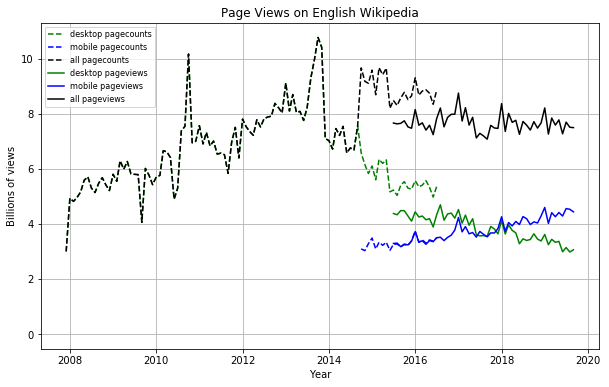

In [15]:
# Plot the time series of pagecount and pageview data by access type
plt.plot('date', 'pagecount_desktop_views', data=df_all_plot, color='green', linestyle='dashed', label='desktop pagecounts')
plt.plot('date', 'pagecount_mobile_views', data=df_all_plot, color='blue', linestyle='dashed', label='mobile pagecounts')
plt.plot('date', 'pagecount_all_views', data=df_all_plot, color='black', linestyle='dashed', label='all pagecounts')
plt.plot('date', 'pageview_desktop_views', data=df_all_plot, color='green', label='desktop pageviews')
plt.plot('date', 'pageview_mobile_views', data=df_all_plot, color='blue', label='mobile pageviews')
plt.plot('date', 'pageview_all_views', data=df_all_plot, color='black', label='all pageviews')

# Label axes, create legend, and format the figure
plt.ylabel('Billions of views')
plt.xlabel('Year')
plt.title('Page Views on English Wikipedia')
plt.legend(loc='upper left', ncol = 1, prop={'size': 8})
plt.grid()
plt.axhline(y=0, color='k', linewidth = 0)

# Save out a JPEG of the figure
fig1 = plt.gcf()
fig1.set_size_inches(10, 6)
fig1.savefig('../results/visualization.jpeg', dpi = 600, bbox_inches='tight')

plt.show()

From this figure, we can see the trends in pagecount and pageview data. First, we note an increasing trend in total pagecounts from 2008 to 2016. In contrast, the more recent total pageviews trend appears pretty flat from 2016 to 2019. We also note the magnitude of the total pageviews data is about 1 billion lower compared to the total pagecounts data in the overlapping period from July 2015 to July 2016; this is likely due to the inclusion of views from web crawlers and spiders in the pagecounts data, which is a limitation of the dataset and results in an overestimation of organic traffic to the website. We can also see a declining trend in desktop access over time, while mobile access has increased, as smartphone use and mobile web browsing have incresed over time. Whereas desktop access made up the majority of page access in the past, it has now been surpassed by mobile access.